## Data Preparation

In [39]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
ignore_warnings = True
import seaborn as sns
import json


In [40]:
import os
import pandas as pd

# ───────────────────────────────
# 1. Rutas candidatas
# ───────────────────────────────
candidate_paths = [
    "../data/raw/insurance_company_modified.csv"
]

# ───────────────────────────────
# 2. Detección automática de ruta
# ───────────────────────────────
path_used = next((p for p in candidate_paths if os.path.exists(p)), None)

if path_used is None:
    raise FileNotFoundError(f"No se encontró el CSV en ninguna de las rutas: {candidate_paths}")

# ───────────────────────────────
# 3. Cargar el dataset
# ───────────────────────────────
df = pd.read_csv(path_used)
print(f"[INFO] Archivo cargado correctamente: {path_used}")
print(f"[INFO] Dimensiones iniciales: {df.shape}")




[INFO] Archivo cargado correctamente: ../data/raw/insurance_company_modified.csv
[INFO] Dimensiones iniciales: (5937, 87)


In [41]:
dd_names = [
    "MOSTYPE","MAANTHUI","MGEMOMV","MGEMLEEF","MOSHOOFD","MGODRK","MGODPR","MGODOV","MGODGE","MRELGE",
    "MRELSA","MRELOV","MFALLEEN","MFGEKIND","MFWEKIND","MOPLHOOG","MOPLMIDD","MOPLLAAG","MBERHOOG","MBERZELF",
    "MBERBOER","MBERMIDD","MBERARBG","MBERARBO","MSKA","MSKB1","MSKB2","MSKC","MSKD","MHHUUR",
    "MHKOOP","MAUT1","MAUT2","MAUT0","MZFONDS","MZPART","MINKM30","MINK3045","MINK4575","MINK7512",
    "MINK123M","MINKGEM","MKOOPKLA","PWAPART","PWABEDR","PWALAND","PPERSAUT","PBESAUT","PMOTSCO","PVRAAUT",
    "PAANHANG","PTRACTOR","PWERKT","PBROM","PLEVEN","PPERSONG","PGEZONG","PWAOREG","PBRAND","PZEILPL",
    "PPLEZIER","PFIETS","PINBOED","PBYSTAND","AWAPART","AWABEDR","AWALAND","APERSAUT","ABESAUT","AMOTSCO",
    "AVRAAUT","AAANHANG","ATRACTOR","AWERKT","ABROM","ALEVEN","APERSONG","AGEZONG","AWAOREG","ABRAND",
    "AZEILPL","APLEZIER","AFIETS","AINBOED","ABYSTAND","CARAVAN"
]

dd_desc = [
    "Customer Subtype (see L0)","Number of houses (1–10)","Average household size (1–6)","Average age (see L1)",
    "Customer main type (see L2)","Roman catholic (see L3)","Protestant (see L3)","Other religion (see L3)",
    "No religion (see L3)","Married","Living together","Other relation","Singles","Household without children",
    "Household with children","High level education","Medium level education","Lower level education","High status",
    "Entrepreneur","Farmer","Middle management","Skilled labourers","Unskilled labourers","Social class A",
    "Social class B1","Social class B2","Social class C","Social class D","Rented house","Home owners","1 car",
    "2 cars","No car","National Health Service","Private health insurance","Income < 30.000","Income 30-45.000",
    "Income 45-75.000","Income 75-122.000","Income >123.000","Average income","Purchasing power class",
    "Contribution private third party insurance (see L4)",
    "Contribution third party insurance (firms) ...",
    "Contribution third party insurance (agriculture)","Contribution car policies",
    "Contribution delivery van policies","Contribution motorcycle/scooter policies","Contribution lorry policies",
    "Contribution trailer policies","Contribution tractor policies","Contribution agricultural machines policies",
    "Contribution moped policies","Contribution life insurances",
    "Contribution private accident insurance policies","Contribution family accidents insurance policies",
    "Contribution disability insurance policies","Contribution fire policies","Contribution surfboard policies",
    "Contribution boat policies","Contribution bicycle policies","Contribution property insurance policies",
    "Contribution social security insurance policies","Number of private third party insurance (1–12)",
    "Number of third party insurance (firms) ...","Number of third party insurance (agriculture)","Number of car policies",
    "Number of delivery van policies","Number of motorcycle/scooter policies","Number of lorry policies",
    "Number of trailer policies","Number of tractor policies","Number of agricultural machines policies",
    "Number of moped policies","Number of life insurances","Number of private accident insurance policies",
    "Number of family accidents insurance policies","Number of disability insurance policies","Number of fire policies",
    "Number of surfboard policies","Number of boat policies","Number of bicycle policies","Number of property insurance policies",
    "Number of social security insurance policies","Number of mobile home policies (0–1)"
]

# Diccionario Nombre → Descripción
col_descriptions = {dd_names[i]: dd_desc[i] for i in range(len(dd_names))}

In [42]:
def is_int_like(x: str) -> bool:
    try:
        int(str(x).strip())
        return True
    except Exception:
        return False

# a) Mapeo por NÚMERO "Nr" → nombre
number_to_name = {i+1: dd_names[i] for i in range(len(dd_names))}

# ¿Tenemos al menos una parte significativa de 1..86 como nombres numéricos?
numeric_like_cols = [c for c in df.columns[:86] if is_int_like(c)]
use_numeric_map = len(numeric_like_cols) >= 20  # umbral razonable

rename_map = {}
if use_numeric_map:
    for c in df.columns[:86]:
        if is_int_like(c):
            n = int(str(c).strip())
            if 1 <= n <= 86:
                rename_map[c] = number_to_name[n]
    # Si quedan huecos (no numéricos) en las primeras 86, rellena por posición
    remaining = [c for c in df.columns[:86] if c not in rename_map]
    used_names = set(rename_map.values())
    positional_candidates = [nm for nm in dd_names if nm not in used_names]
    for i, c in enumerate(remaining):
        if i < len(positional_candidates):
            rename_map[c] = positional_candidates[i]
else:
    # Renombrado por posición
    for i in range(min(86, df.shape[1])):
        rename_map[df.columns[i]] = dd_names[i]

df = df.rename(columns=rename_map)

# ------------------------------------------------------------------
# 4) Mapas L0–L4
# ------------------------------------------------------------------
L0 = {
    1:"High Income, expensive child",2:"Very Important Provincials",3:"High status seniors",
    4:"Affluent senior apartments",5:"Mixed seniors",6:"Career and childcare",
    7:"Dinki's (double income no kids)",8:"Middle class families",9:"Modern, complete families",
    10:"Stable family",11:"Family starters",12:"Affluent young families",13:"Young all american family",
    14:"Junior cosmopolitan",15:"Senior cosmopolitans",16:"Students in apartments",
    17:"Fresh masters in the city",18:"Single youth",19:"Suburban youth",20:"Etnically diverse",
    21:"Young urban have-nots",22:"Mixed apartment dwellers",23:"Young and rising",
    24:"Young, low educated",25:"Young seniors in the city",26:"Own home elderly",27:"Seniors in apartments",
    28:"Residential elderly",29:"Porchless seniors: no front yard",30:"Religious elderly singles",
    31:"Low income catholics",32:"Mixed seniors",33:"Lower class large families",
    34:"Large family, employed child",35:"Village families",
    36:"Couples with teens 'Married with children'",37:"Mixed small town dwellers",
    38:"Traditional families",39:"Large religous families",40:"Large family farms",41:"Mixed rurals"
}
L1 = {1:"20-30 years",2:"30-40 years",3:"40-50 years",4:"50-60 years",5:"60-70 years",6:"70-80 years"}
L2 = {1:"Successful hedonists",2:"Driven Growers",3:"Average Family",4:"Career Loners",5:"Living well",
      6:"Cruising Seniors",7:"Retired and Religeous",8:"Family with grown ups",9:"Conservative families",10:"Farmers"}
L3 = {0:"0%",1:"1 - 10%",2:"11 - 23%",3:"24 - 36%",4:"37 - 49%",5:"50 - 62%",6:"63 - 75%",7:"76 - 88%",8:"89 - 99%",9:"100%"}
L4 = {0:"f 0",1:"f 1 – 49",2:"f 50 – 99",3:"f 100 – 199",4:"f 200 – 499",5:"f 500 – 999",
      6:"f 1000 – 4999",7:"f 5000 – 9999",8:"f 10.000 - 19.999",9:"f 20.000 - ?"}


In [43]:
df = df.drop(columns=["mixed_type_col"])

In [44]:
def to_int_nullable(s):
    """Convierte a entero (Int64) tolerando NaN/strings."""
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def add_label(df, base_col, mapping, suffix="_label"):
    """Crea {base_col}_label (dtype category) a partir de un mapping de códigos→texto."""
    if base_col not in df.columns:
        return df
    df[base_col] = to_int_nullable(df[base_col])
    label_col = f"{base_col}{suffix}"
    df[label_col] = df[base_col].map(mapping)
    # categorías únicas para evitar ValueError por duplicados
    uniq_cats = pd.Index(mapping.values(), dtype="object").unique()
    df[label_col] = df[label_col].astype(CategoricalDtype(categories=list(uniq_cats), ordered=False))
    return df

In [45]:
df = add_label(df, "MOSTYPE", L0)        # L0
df = add_label(df, "MGEMLEEF", L1)       # L1
df = add_label(df, "MOSHOOFD", L2)       # L2
for c in ["MGODRK", "MGODPR", "MGODOV", "MGODGE"]:  # L3
    df = add_label(df, c, L3)
for c in ["PWAPART", "PWABEDR", "PWALAND"]:         # L4
    df = add_label(df, c, L4)


In [46]:
import os
import json
import pandas as pd

# Asumimos que ya tienes la variable path_used del CSV original
base_dir = os.path.dirname(path_used) if os.path.dirname(path_used) else "."

# ───────────────────────────────
# 1️⃣ Crear carpeta de salida
# ───────────────────────────────
# Ruta absoluta hacia /data/enriched
out_dir = os.path.join(base_dir, "../enriched")
os.makedirs(out_dir, exist_ok=True)  # crea si no existe

# ───────────────────────────────
# 2️⃣ Guardar CSV enriquecido
# ───────────────────────────────
out_csv = os.path.join(out_dir, "insurance_company_enriched.csv")
df.to_csv(out_csv, index=False)
print(f"[INFO] CSV enriquecido guardado en: {os.path.abspath(out_csv)}")

# ───────────────────────────────
# 3️⃣ Guardar Data Dictionary (JSON)
# ───────────────────────────────
dd_json = os.path.join(out_dir, "data_dictionary.json")
with open(dd_json, "w", encoding="utf-8") as f:
    json.dump(col_descriptions, f, ensure_ascii=False, indent=2)
print(f"[INFO] Data Dictionary (JSON) guardado en: {os.path.abspath(dd_json)}")

# ───────────────────────────────
# 4️⃣ Guardar Data Dictionary (Markdown)
# ───────────────────────────────
dd_md = os.path.join(out_dir, "data_dictionary.md")
with open(dd_md, "w", encoding="utf-8") as f:
    f.write("| Column | Description |\n|---|---|\n")
    for name in dd_names:
        f.write(f"| {name} | {col_descriptions[name]} |\n")
print(f"[INFO] Data Dictionary (MD) guardado en: {os.path.abspath(dd_md)}")


[INFO] CSV enriquecido guardado en: /Users/jfts/Documents/ML_OPS_PROYECT/mlops_proyect/data/enriched/insurance_company_enriched.csv
[INFO] Data Dictionary (JSON) guardado en: /Users/jfts/Documents/ML_OPS_PROYECT/mlops_proyect/data/enriched/data_dictionary.json
[INFO] Data Dictionary (MD) guardado en: /Users/jfts/Documents/ML_OPS_PROYECT/mlops_proyect/data/enriched/data_dictionary.md


# EDA

In [25]:
file_path = "../data/enriched/insurance_company_enriched.csv"  # ajusta si es necesario
df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("Columnas:", df.columns[:])

Shape: (5937, 97)
Columnas: Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK',
       'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG',
       'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA',
       'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
       'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575',
       'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR',
       'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG',
       'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG',
       'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED',
       'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT',
       'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM',
       'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL',


In [26]:
print("\n=== Info ===")
df.info()

print("\n=== Valores nulos ===")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print("\n=== Descripción numérica ===")
print(df.describe().T.head(15))


=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 97 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MOSTYPE         5849 non-null   float64
 1   MAANTHUI        5864 non-null   object 
 2   MGEMOMV         5873 non-null   object 
 3   MGEMLEEF        5844 non-null   float64
 4   MOSHOOFD        5851 non-null   float64
 5   MGODRK          5842 non-null   float64
 6   MGODPR          5836 non-null   float64
 7   MGODOV          5856 non-null   float64
 8   MGODGE          5855 non-null   float64
 9   MRELGE          5876 non-null   object 
 10  MRELSA          5871 non-null   object 
 11  MRELOV          5871 non-null   object 
 12  MFALLEEN        5871 non-null   object 
 13  MFGEKIND        5852 non-null   object 
 14  MFWEKIND        5877 non-null   object 
 15  MOPLHOOG        5866 non-null   object 
 16  MOPLMIDD        5874 non-null   object 
 17  MOPLLAAG        587

In [28]:
cat_cols = [c for c in df.columns if c.endswith("_label")]
print("\n=== Columnas categóricas etiquetadas ===", cat_cols)

for col in cat_cols:
    print(f"\nDistribución {col}:")
    print(df[col].value_counts(normalize=True).head(10))


=== Columnas categóricas etiquetadas === ['MOSTYPE_label', 'MGEMLEEF_label', 'MOSHOOFD_label', 'MGODRK_label', 'MGODPR_label', 'MGODOV_label', 'MGODGE_label', 'PWAPART_label', 'PWABEDR_label', 'PWALAND_label']

Distribución MOSTYPE_label:
MOSTYPE_label
Lower class large families                    0.139764
Middle class families                         0.059058
Traditional families                          0.058885
Large religous families                       0.055594
Modern, complete families                     0.048320
High status seniors                           0.042432
Young and rising                              0.041912
Couples with teens 'Married with children'    0.038621
Village families                              0.036024
Mixed rurals                                  0.034984
Name: proportion, dtype: float64

Distribución MGEMLEEF_label:
MGEMLEEF_label
40-50 years    0.511003
30-40 years    0.251083
50-60 years    0.186103
60-70 years    0.033616
20-30 years    0.01264

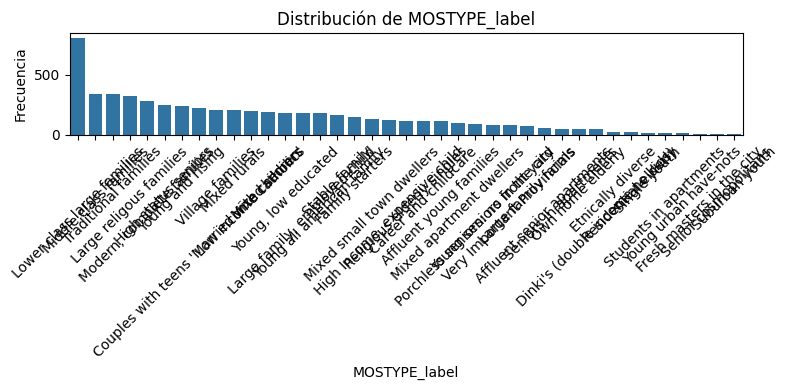

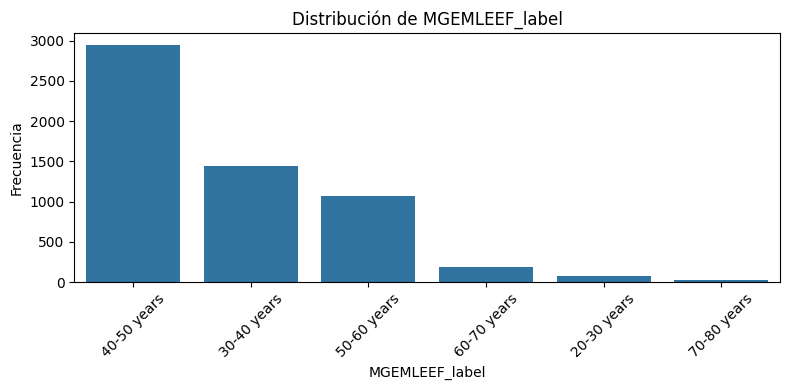

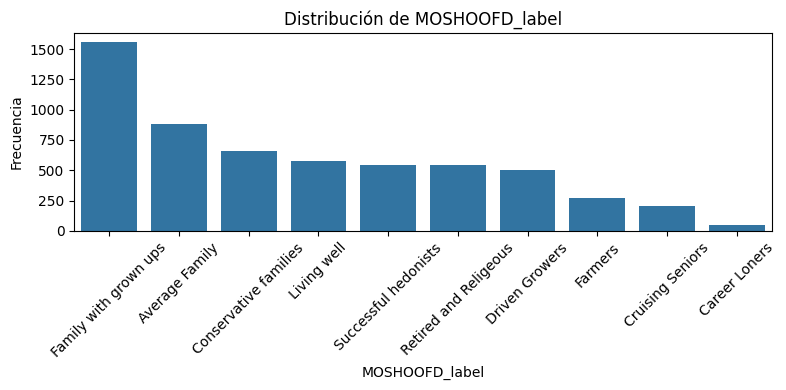

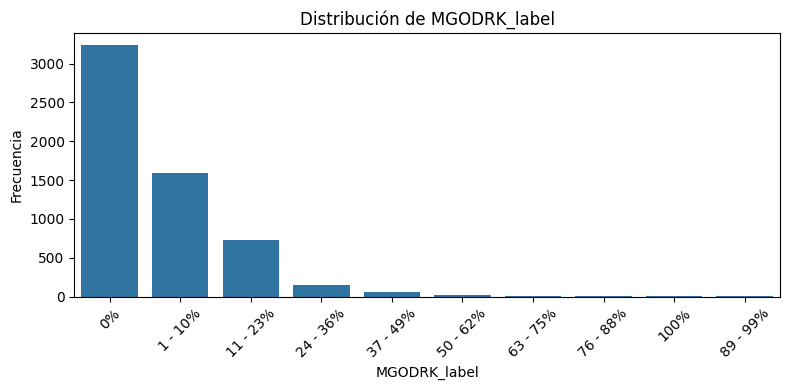

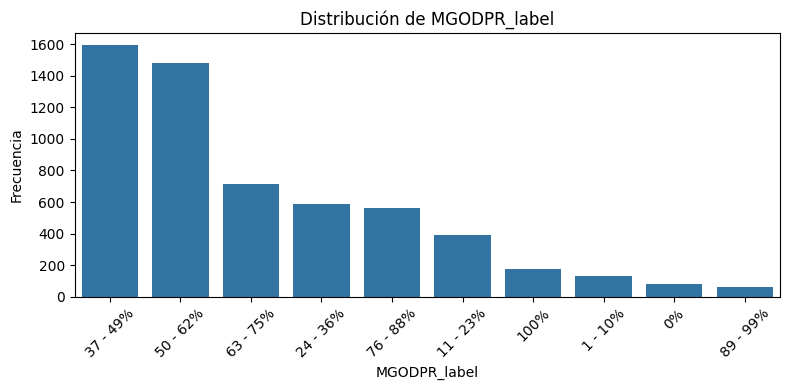

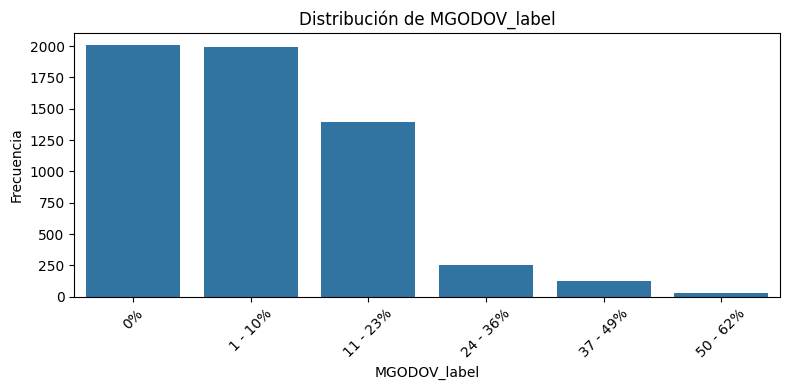

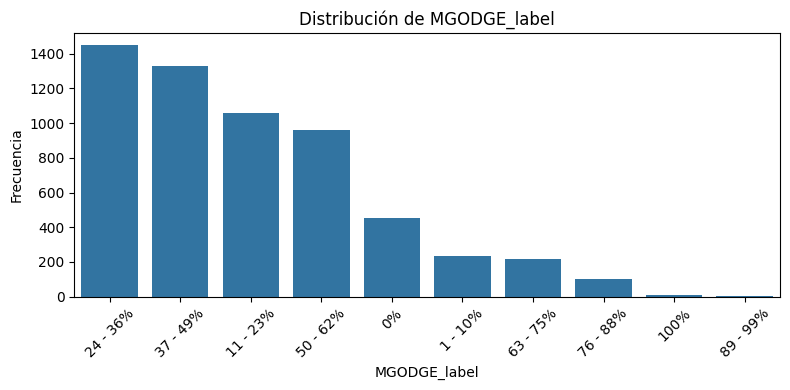

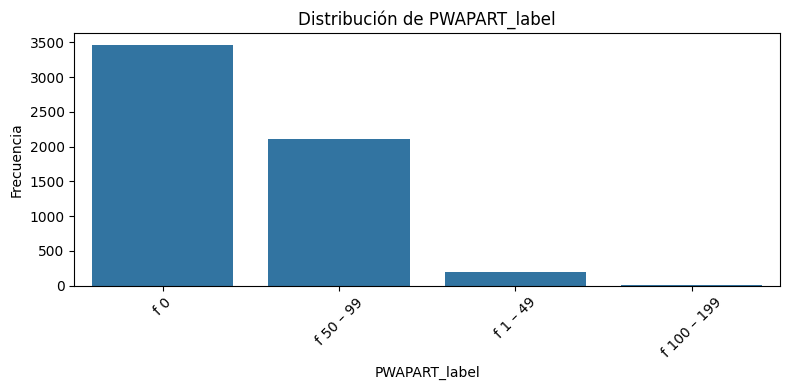

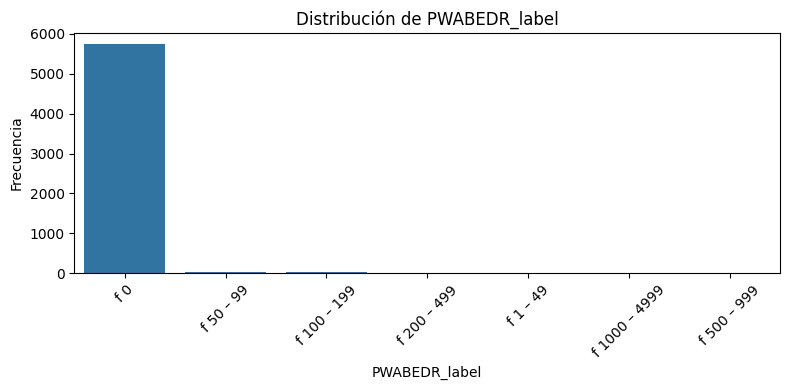

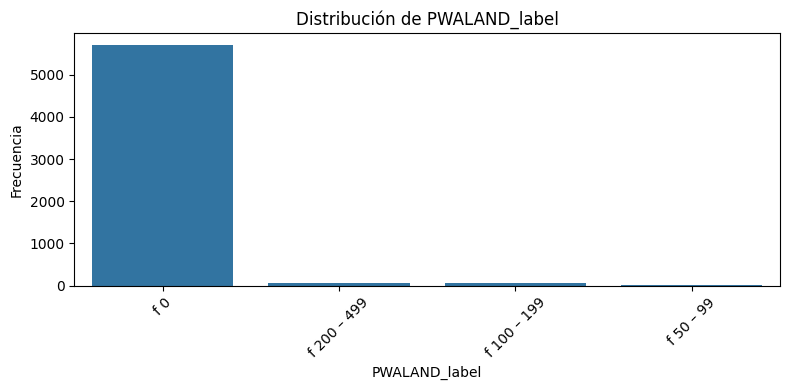

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

for cal in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=cal, data=df, order=df[cal].value_counts().index)
    plt.title(f"Distribución de {cal}")
    plt.xlabel(cal)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)  # gira etiquetas si son largas
    plt.tight_layout()
    plt.show()

 




=== Columnas numéricas candidatas === ['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK', 'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN', 'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG', 'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA', 'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2', 'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED', 'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND', 'CARAVAN', 'mixed_type_col']
MOSTY

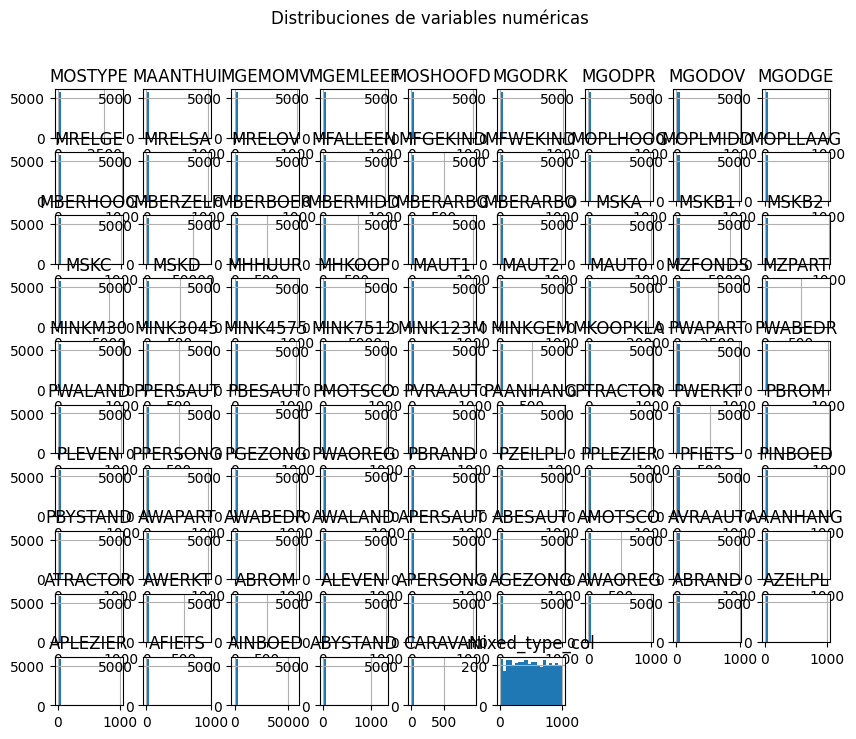

In [31]:
num_cols = [c for c in df.columns if c not in cat_cols and not c.endswith("_label")]
print("\n=== Columnas numéricas candidatas ===", num_cols)

# Forzar a numérico (los valores inválidos se vuelven NaN)
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df[num_cols].dtypes)  # verificar que son numéricas ahora

# Ahora sí graficar
df[num_cols].hist(figsize=(10,8), bins=20)
plt.suptitle("Distribuciones de variables numéricas")
plt.show()


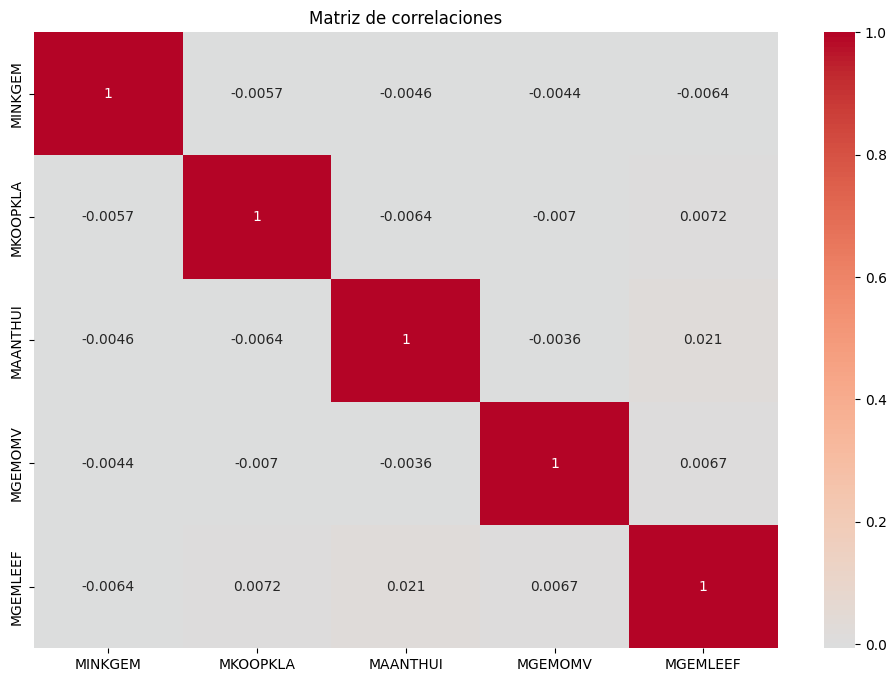

In [29]:
plt.figure(figsize=(12,8))
corr = df[num_cols + ["MGEMLEEF"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlaciones")
plt.show()


count     5937.000000
mean        68.054741
std        768.068509
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max      57351.000000
Name: total_policies, dtype: float64


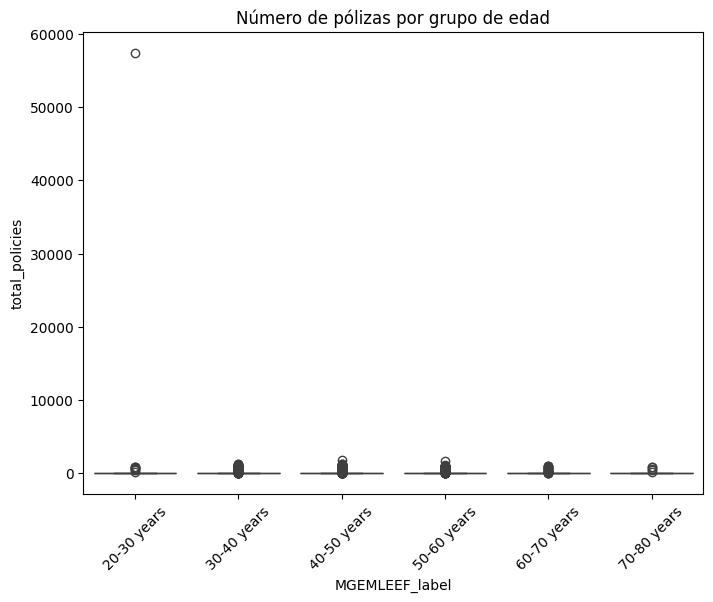

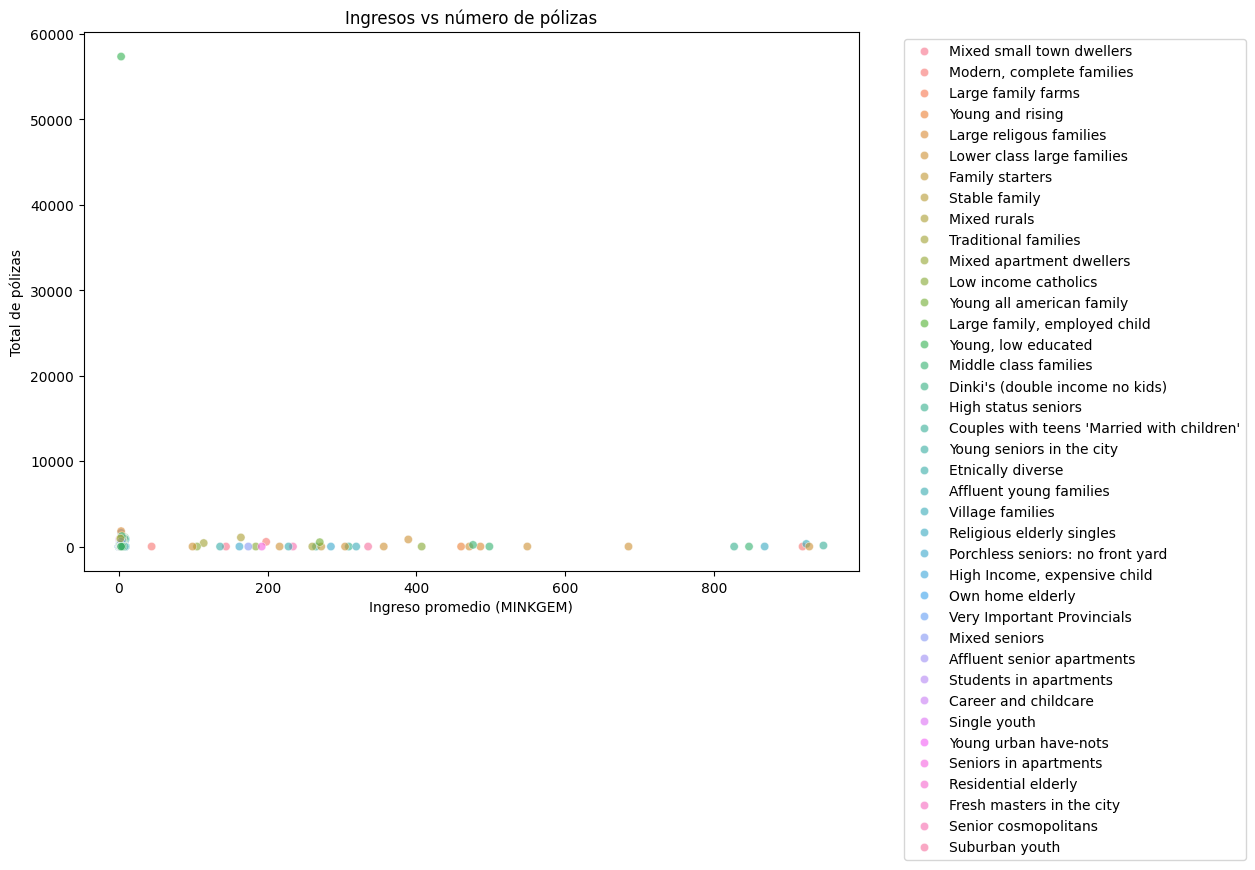

In [30]:
# Seleccionar columnas de pólizas (las que empiezan con "A")
policy_cols = [c for c in df.columns if c.startswith("A")]

# Forzar conversión a numérico: si hay strings no válidos, se convierten en NaN
df[policy_cols] = df[policy_cols].apply(pd.to_numeric, errors="coerce")

# Calcular total de pólizas
df["total_policies"] = df[policy_cols].sum(axis=1)

print(df["total_policies"].describe())
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x="MGEMLEEF_label", y="total_policies", data=df)
plt.title("Número de pólizas por grupo de edad")
plt.xticks(rotation=45)
plt.show()

# Scatterplot
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="MINKGEM", 
    y="total_policies", 
    hue="MOSTYPE_label", 
    data=df, 
    alpha=0.6
)
plt.title("Ingresos vs número de pólizas")
plt.xlabel("Ingreso promedio (MINKGEM)")
plt.ylabel("Total de pólizas")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
